In [1]:
from keras.layers import Input, Dense, GaussianNoise, Lambda, Dropout, concatenate, LSTM, Add, Multiply, Layer
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
import numpy as np
import keras
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.utils import plot_model
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from utils import *
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Using TensorFlow backend.


In [2]:
H = K.constant([[1, 1]])
SNR1 = 7
SNR2 = 7
SNRs = [SNR1, SNR2]
ebno = [calc_ebno(SNR) for SNR in SNRs]

k = 2
n_channel = 2
M = 2 ** k
k = int(k)
R = k / n_channel

In [3]:
input_signal1 = Input(shape=(M,), name="input1")
input_signal2 = Input(shape=(M,), name="input2")
encoder1 = create_encoder([M, n_channel], name="encoder1", activations=["relu", "linear"])
encoder2 = create_encoder([M, n_channel], name="encoder2", activations=["relu", "linear"])

combiner = create_combiner(layer_sizes=[n_channel * 4, n_channel], activations=["relu", "tanh"], name="combiner")

signal_input2 = create_inputs(R=R, H=H, t=0, k=1, ebno=ebno, name="transmit2")
signal_input1 = create_inputs(R=R, H=H, t=0, k=0, ebno=ebno, name="transmit1")

decoder1 = create_decoder([M * 4, M * 2, M], name="decoder1", activation="relu")

decoder2 = create_decoder([M * 4, M * 2, M], name="decoder2", activation="relu")

x1 = encoder1(input_signal1)
x2 = encoder1(input_signal2)
x = concatenate([x1, x2], axis=1)
x = combiner(x)
x1 = signal_input1(x)
x2 = signal_input2(x)
out1 = decoder1(x1)
out2 = decoder2(x2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
model = Model(inputs=[input_signal1, input_signal2], outputs=[out1, out2])
model.summary()
alpha = K.variable(.5)

optim = SGD(momentum=.9)

model.compile(optimizer="rmsprop", loss=["categorical_crossentropy", "categorical_crossentropy"],
            loss_weights=[alpha, (1 - alpha)], metrics=["accuracy", BER])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
encoder1 (Sequential)           (None, 2)            34          input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 4)            0           encoder1[1][0]             

In [5]:
train_datas = generate_train_datas(k=2)

model.fit(x=train_datas, y=train_datas, validation_split=.5, batch_size=40000,
    epochs=2000, callbacks=[
    EarlyStopping(patience=100, restore_best_weights=True, monitor="loss", mode="min"),
    ReduceLROnPlateau(monitor="loss", factor=.5, patience=20),
    AlphaCallback(alpha),
])

: 0.8822 - val_decoder2_BER: 0.0589
Epoch 561/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2901 - decoder1_loss: 0.2897 - decoder2_loss: 0.2904 - decoder1_accuracy: 0.8812 - decoder1_BER: 0.0594 - decoder2_accuracy: 0.8807 - decoder2_BER: 0.0596 - val_loss: 0.2882 - val_decoder1_loss: 0.2891 - val_decoder2_loss: 0.2873 - val_decoder1_accuracy: 0.8821 - val_decoder1_BER: 0.0589 - val_decoder2_accuracy: 0.8825 - val_decoder2_BER: 0.0587
Epoch 562/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2895 - decoder1_loss: 0.2892 - decoder2_loss: 0.2899 - decoder1_accuracy: 0.8823 - decoder1_BER: 0.0589 - decoder2_accuracy: 0.8820 - decoder2_BER: 0.0590 - val_loss: 0.2883 - val_decoder1_loss: 0.2884 - val_decoder2_loss: 0.2883 - val_decoder1_accuracy: 0.8819 - val_decoder1_BER: 0.0590 - val_decoder2_accuracy: 0.8824 - val_decoder2_BER: 0.0588
Epoch 563/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2882 - dec

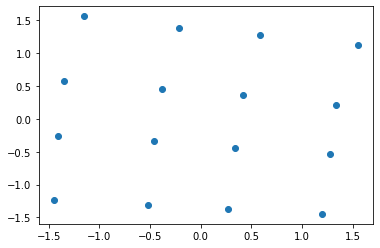